Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Monte Carlo Results:
Expected final value: 139,102.07
5th percentile (VaR-like): 96,792.53
95th percentile: 191,062.20
Probability of loss: 6.85%


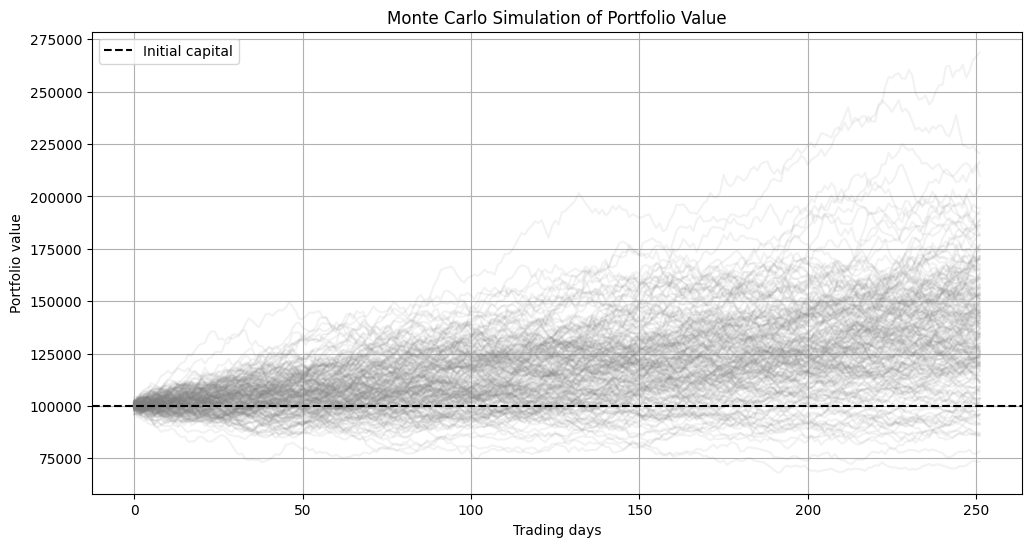

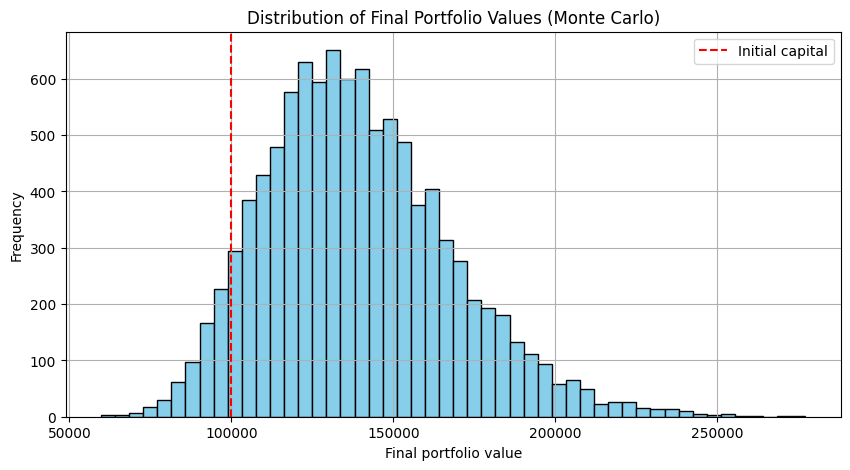

In [19]:
# ================================================
# MONTE CARLO SIMULATION - PORTFOLIO RISK ANALYSIS
# ================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Directorios
BASE = Path('/content/drive/MyDrive/ProyectoCartera')
PROCESSED_DIR = BASE / 'data' / 'processed'

# 1️ Cargar precios limpios
prices = pd.read_csv(PROCESSED_DIR / 'prices.csv', index_col=0, parse_dates=True)

# Limpiar el índice y los datos numéricos en el DataFrame de precios
prices.index = pd.to_datetime(prices.index, errors='coerce') # Convierte el índice a DatetimeIndex, los valores no válidos se convierten a NaT
prices = prices[prices.index.notna()] # Elimina filas donde el índice no es una fecha válida

prices = prices.apply(pd.to_numeric, errors='coerce') # Convierte todas las columnas a numérico, los valores no numéricos se convierten a NaN
prices = prices.dropna(how='all') # Elimina filas que son completamente NaN después de la conversión (si hubiera alguna)

# 2️ Calcular retornos diarios
returns = prices.pct_change().dropna(how='all')

# 3️ Definir pesos de la cartera optimizada (ejemplo de última optimización)
weights = {
    'AMZN': 0.0242,
    'GLD': 0.5789,
    'MSFT': 0.0276,
    'NVDA': 0.3692
    # resto activos con 0 peso
}

# Asegurar que todos los tickers estén en el DataFrame
weights = {k:v for k,v in weights.items() if k in returns.columns}

# 4️ Simular valor de la cartera
initial_capital = 100_000  # € o $ inicial
weights_array = np.array([weights.get(ticker, 0) for ticker in returns.columns])
portfolio_daily_returns = (returns * weights_array).sum(axis=1)
portfolio_value = initial_capital * (1 + portfolio_daily_returns).cumprod()

# --- Parámetros ---
n_simulations = 10_000
n_days = 252
initial_capital = 100_000

# --- Retornos históricos de la cartera ---
portfolio_daily_returns = portfolio_daily_returns.dropna()

mu_mc = portfolio_daily_returns.mean()
sigma_mc = portfolio_daily_returns.std()

# --- Simulación Monte Carlo ---
simulated_paths = np.zeros((n_days, n_simulations))

for i in range(n_simulations):
    random_returns = np.random.normal(mu_mc, sigma_mc, n_days)
    simulated_paths[:, i] = initial_capital * np.cumprod(1 + random_returns)

# --- Resultados finales ---
final_values = simulated_paths[-1, :]

# --- Métricas Monte Carlo ---
expected_value = final_values.mean()
percentile_5 = np.percentile(final_values, 5)
percentile_95 = np.percentile(final_values, 95)
prob_loss = np.mean(final_values < initial_capital)

print("📊 Monte Carlo Results:")
print(f"Expected final value: {expected_value:,.2f}")
print(f"5th percentile (VaR-like): {percentile_5:,.2f}")
print(f"95th percentile: {percentile_95:,.2f}")
print(f"Probability of loss: {prob_loss:.2%}")

# --- Visualización ---
plt.figure(figsize=(12,6))
plt.plot(simulated_paths[:, :200], color='gray', alpha=0.1)
plt.axhline(initial_capital, color='black', linestyle='--', label="Initial capital")
plt.title("Monte Carlo Simulation of Portfolio Value")
plt.xlabel("Trading days")
plt.ylabel("Portfolio value")
plt.legend()
plt.grid(True)
plt.show()

# --- Distribución final ---
plt.figure(figsize=(10,5))
plt.hist(final_values, bins=50, color='skyblue', edgecolor='black')
plt.axvline(initial_capital, color='red', linestyle='--', label="Initial capital")
plt.title("Distribution of Final Portfolio Values (Monte Carlo)")
plt.xlabel("Final portfolio value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()